In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from statsmodels.tsa.seasonal import seasonal_decompose


import os

In calculating workload, found that some departments in Oakland and DC have typos, overlaps, or are subcategories of each other. The mapping below was based on research in the 311 data portals interfaces and city government websites.

In [26]:
mapframe = pd.DataFrame([
    ('oakland','ROW_STREETSW','ROW'), # ROW = Right of Way. ROW_STREETSW = Right of Way Streets and Sidewalks, subcategory of ROW
    ('washington','TPPA','PPSA'), # both are PPSA, Policy Planning and Sustainability Administration
    ('washington','STREETLI','STREETLIGHT'), # typo of streetlight
    ('washington','SBM POTHOLES STREETT','POTHOLES'),
    ('washington','SBM POTHOLES ALLEY','POTHOLES'),
], columns=['city','department','new_department'])

mapframe

,city,department,new_department
0,oakland,ROW_STREETSW,ROW
1,washington,TPPA,PPSA
2,washington,STREETLI,STREETLIGHT
3,washington,SBM POTHOLES STREETT,POTHOLES
4,washington,SBM POTHOLES ALLEY,POTHOLES


In [27]:
files = os.listdir('../data/in')
cities = set([f.split("_")[0] for f in files])

newtix = []

for c in cities:
    city = pd.DataFrame()
    print("loading:",c)
    for f in files:
        if c in f:
            tmp = pd.read_csv(
                f"../data/in/{f}",
                parse_dates=['open_date','close_date'],
            )
            city = pd.concat([city,tmp]).reset_index(drop=True)
    city['city'] = c
    city = city.merge(mapframe, on=['city','department'], how='left')
    city.loc[city['new_department'].notna(),'department'] = city.loc[city['new_department'].notna(),'new_department']
    city = time_series_newtix(city, c)
    city.to_csv(f"../data/processed/{c}_newtix.csv", index=False)
    newtix.append(city)

loading: washington
loading: oakland
loading: miami
loading: buffalo
loading: boston


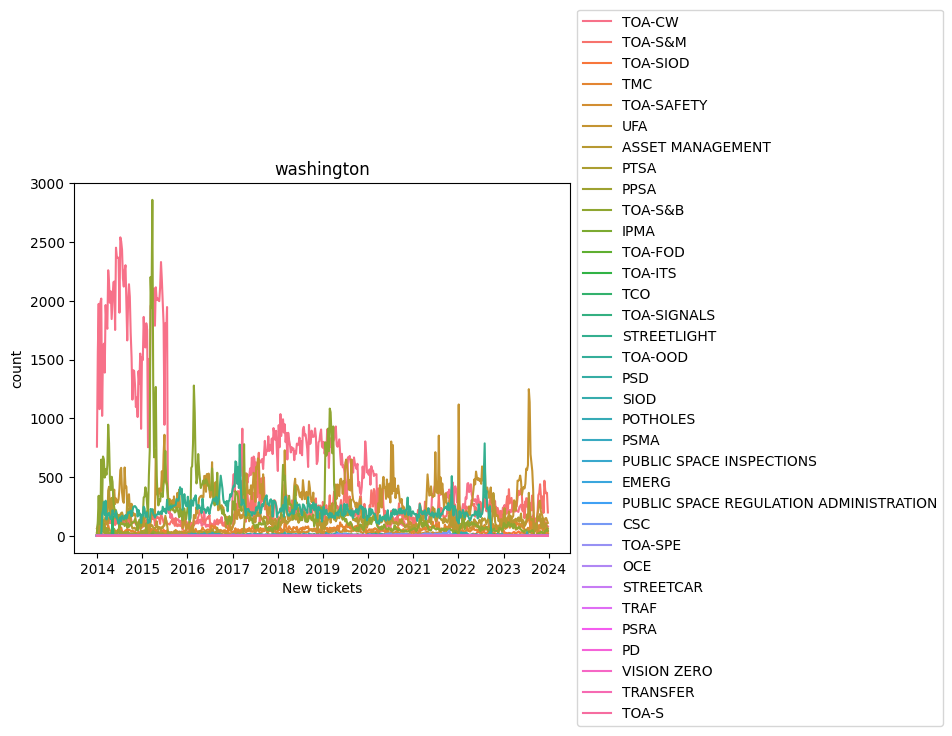

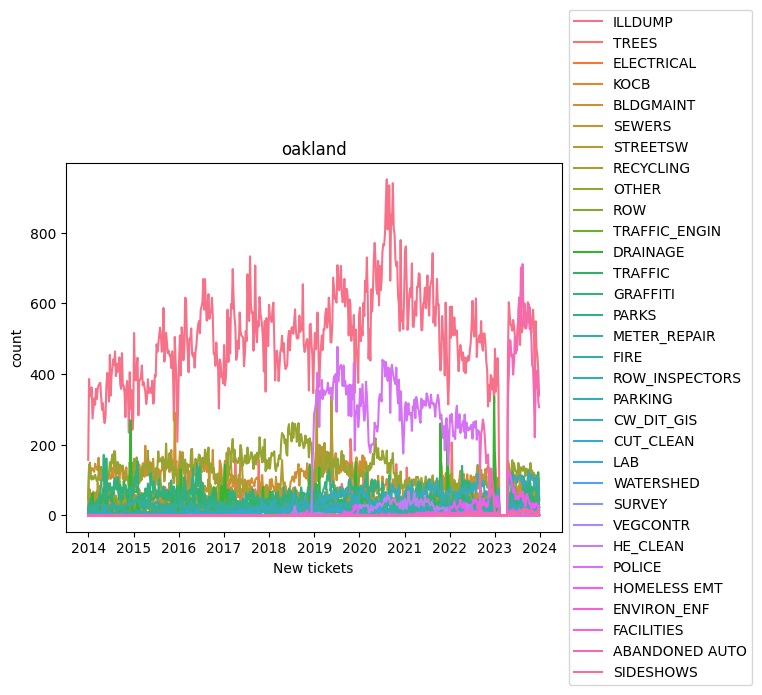

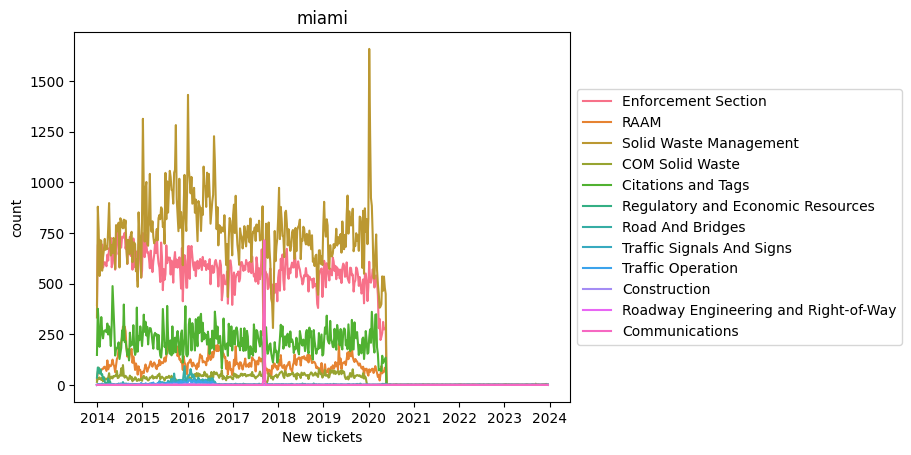

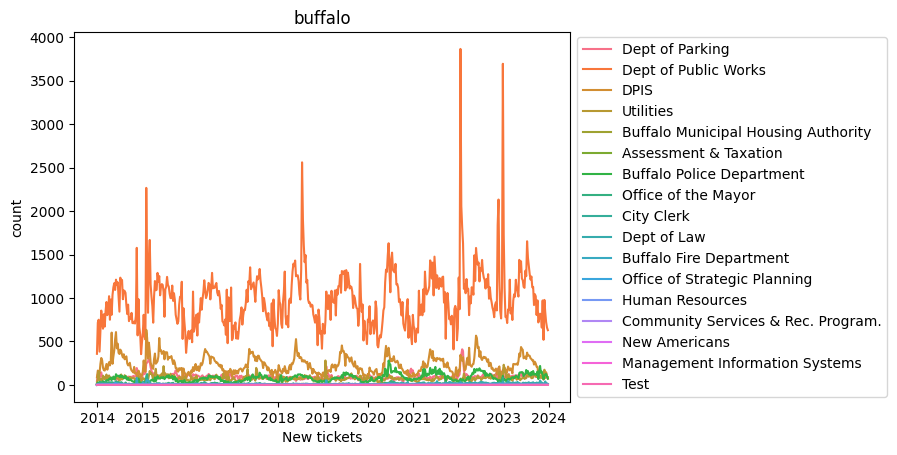

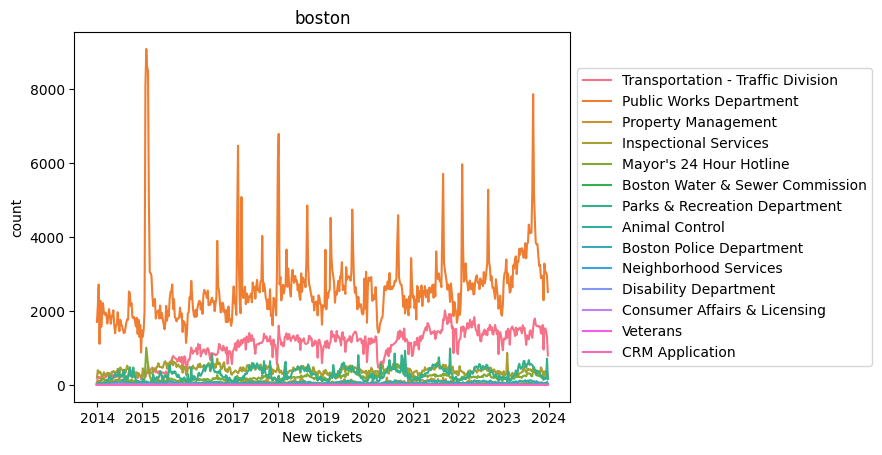

In [28]:
for w in newtix:
    plot = sns.lineplot(data=w, x="week_start", y="count", hue="department")
    plt.title(w['city'].unique()[0])
    plt.xlabel("New tickets")
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')
    plt.show()

In [29]:
merged_df = pd.DataFrame()

for df in newtix:
    merged_df = pd.concat([merged_df,df])

#dropping miami because very little recent data
merged_df = merged_df.loc[merged_df['city'] != 'miami']

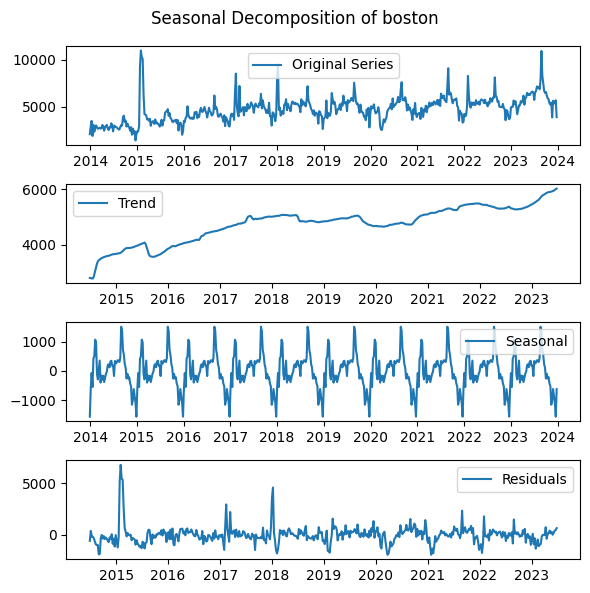

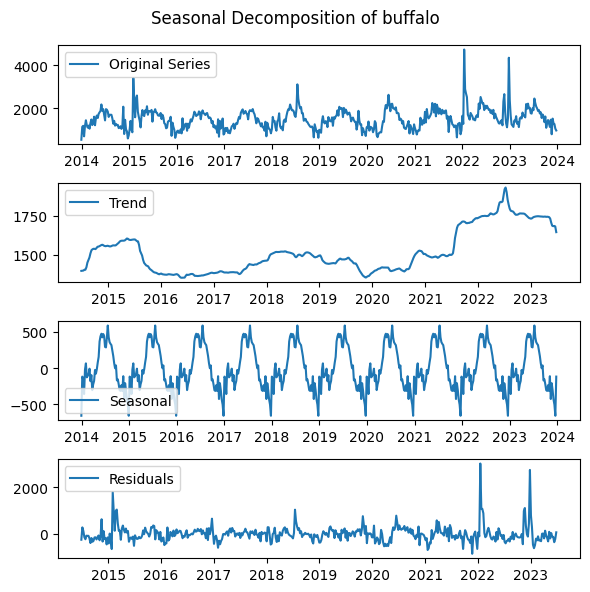

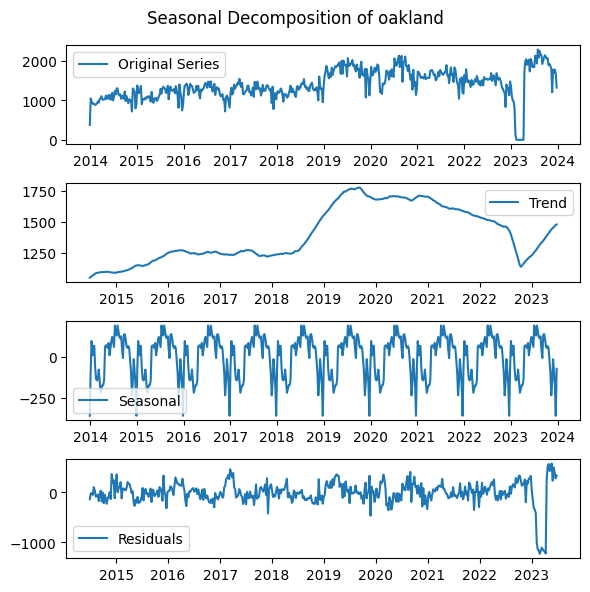

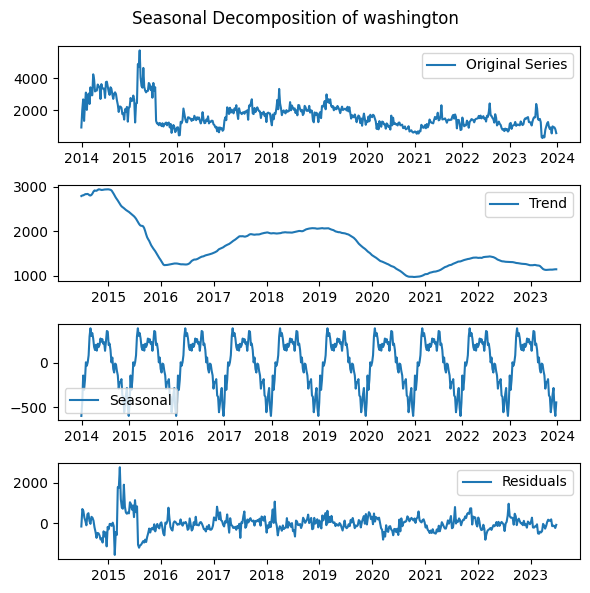

In [30]:
# city level data and seasonality plots

for city, city_df in merged_df.groupby("city"):
    # Perform seasonal decomposition on city level summary data
    df = city_df.groupby("week_start")["count"].sum().reset_index()
    df.set_index("week_start", inplace=True)
    result = seasonal_decompose(df['count'], model = 'additive', period=52)
    trend = result.trend.dropna()
    seasonal = result.seasonal.dropna()
    residual = result.resid.dropna()
    # Plot the decomposition
    fig = plt.figure(figsize=(6,6))
    fig.suptitle(f"Seasonal Decomposition of {city}")
 
    plt.subplot(4, 1, 1)
    plt.plot(df['count'], label='Original Series')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonal')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residuals')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [31]:
# city level data splits

split_date = '2023-01-01'
for city, city_df in merged_df.groupby("city"):
    df = city_df.groupby('week_start')['count'].sum().reset_index()
    train_df = df[df['week_start'] < split_date]
    test_df = df[df['week_start'] >= split_date]

    train_df.to_csv(f'../data/out/{city}_train.csv',index=False)
    test_df.to_csv(f'../data/out/{city}_test.csv',index=False)

In [54]:
# get top 3 departments
# based on median new tickets value and count of nonzero values (don't want departments that were unused for long stretches)

city_depts = merged_df.loc[merged_df['department'].str.lower() != 'other']
top_depts = (
    city_depts[city_depts['week_start'].dt.year >2020]
    .groupby(['city','department'])['count']
    .agg(['median',lambda x: (x!=0).sum()])
    .rename(columns={'<lambda_0>':'nonzero'})
    .reset_index()
    .sort_values(['city','nonzero','median'],ascending=False)
    .groupby('city')
    .head(3)
)
top_depts

,city,department,median,nonzero
94,washington,UFA,256.0,156
81,washington,TOA-CW,233.0,156
87,washington,TOA-S&M,218.0,156
43,oakland,ILLDUMP,518.0,147
47,oakland,PARKING,69.0,147
55,oakland,STREETSW,56.0,147
23,buffalo,Dept of Public Works,1081.0,156
20,buffalo,DPIS,230.5,156
17,buffalo,Buffalo Police Department,105.5,156
11,boston,Public Works Department,2783.0,156


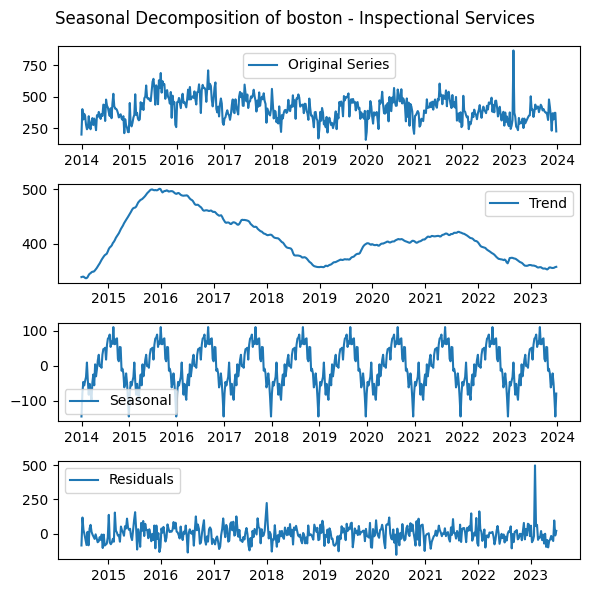

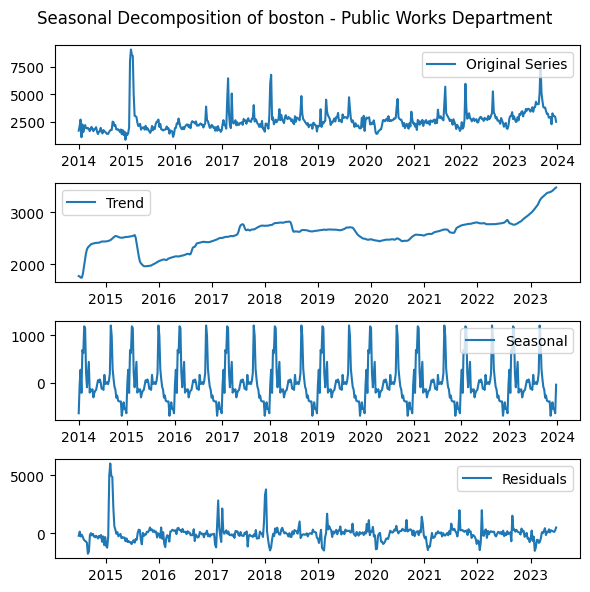

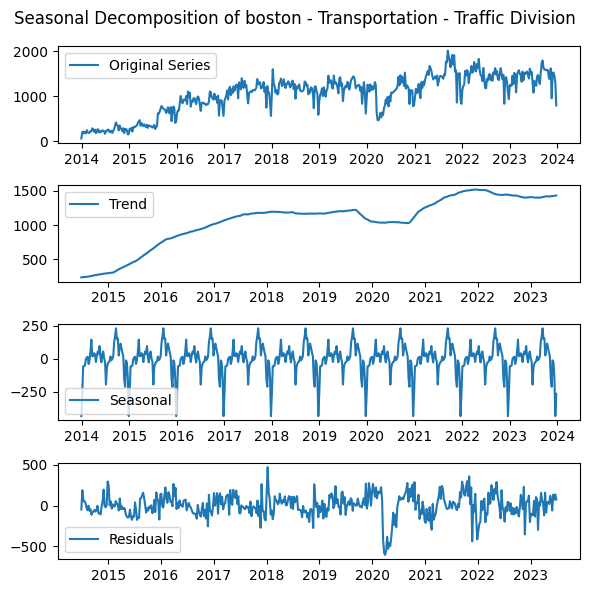

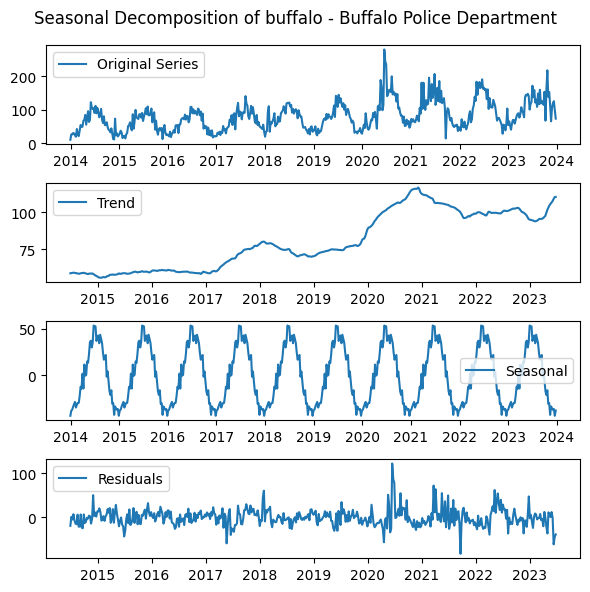

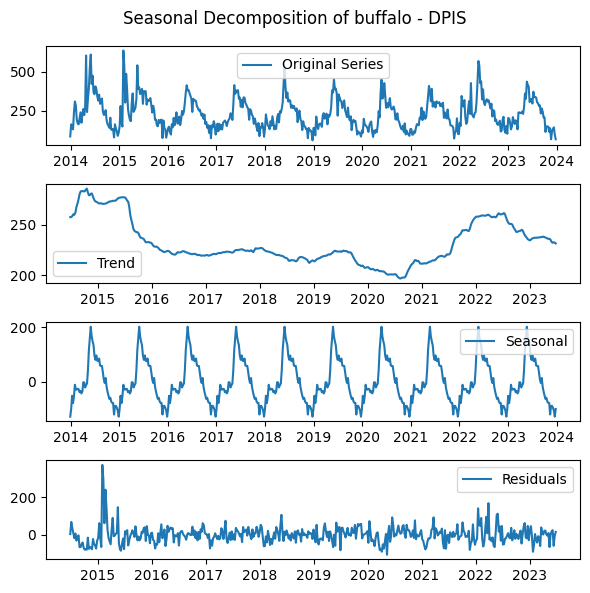

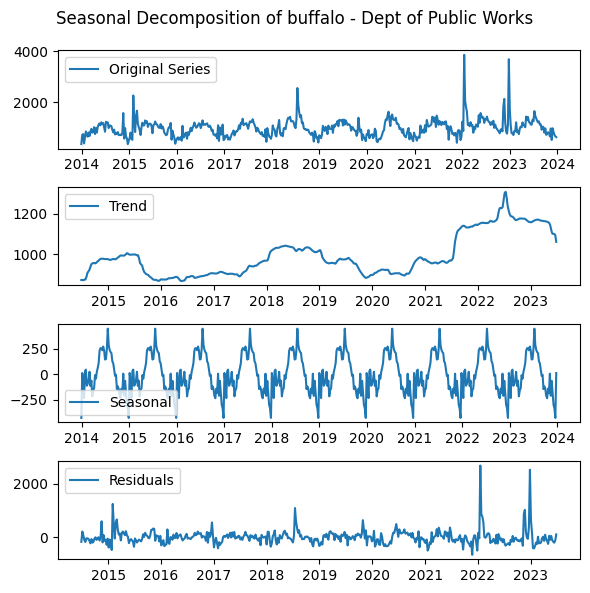

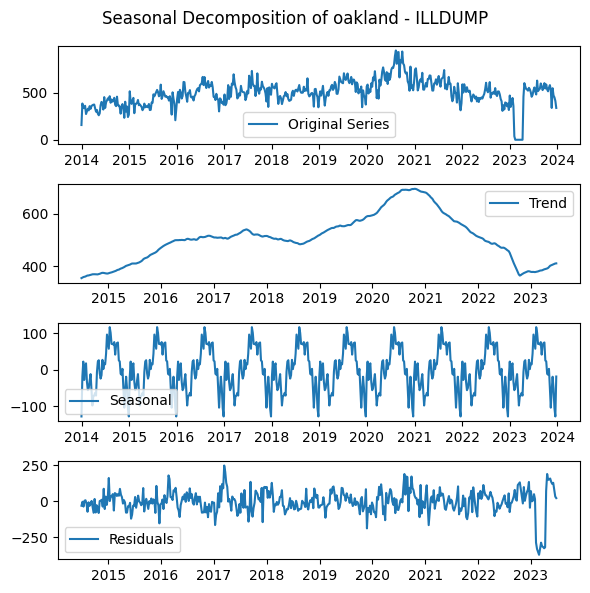

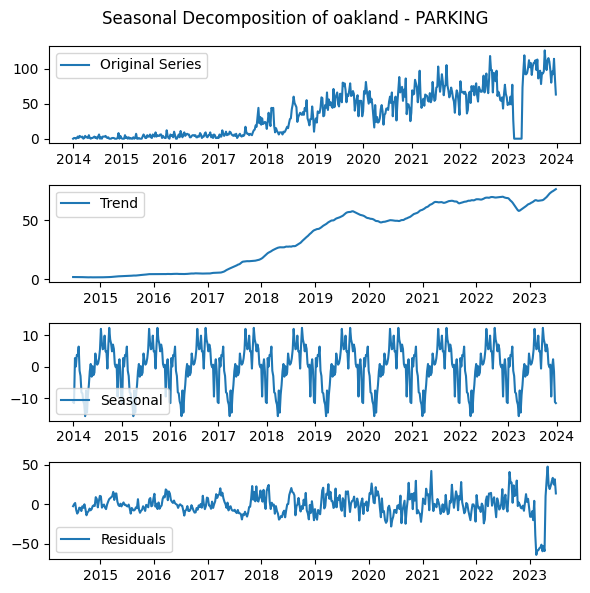

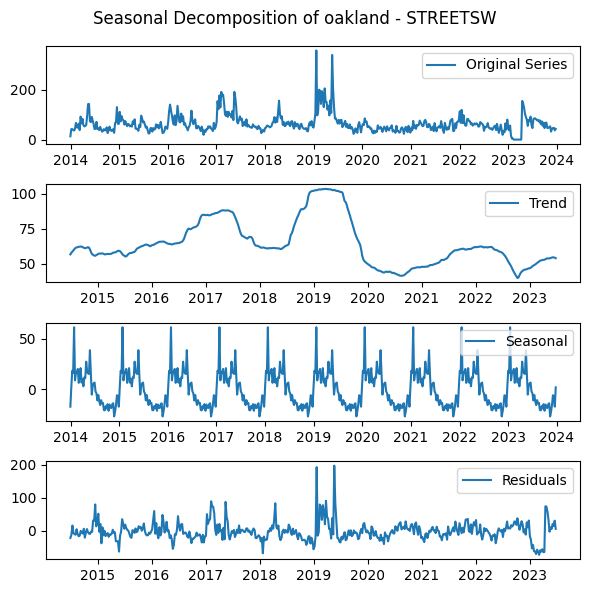

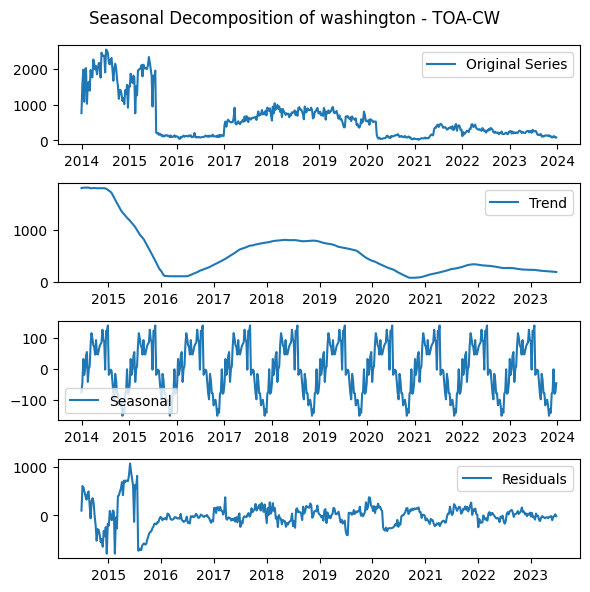

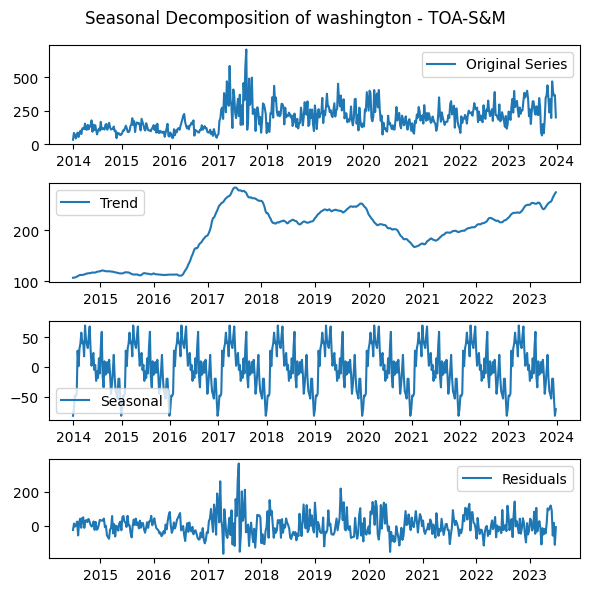

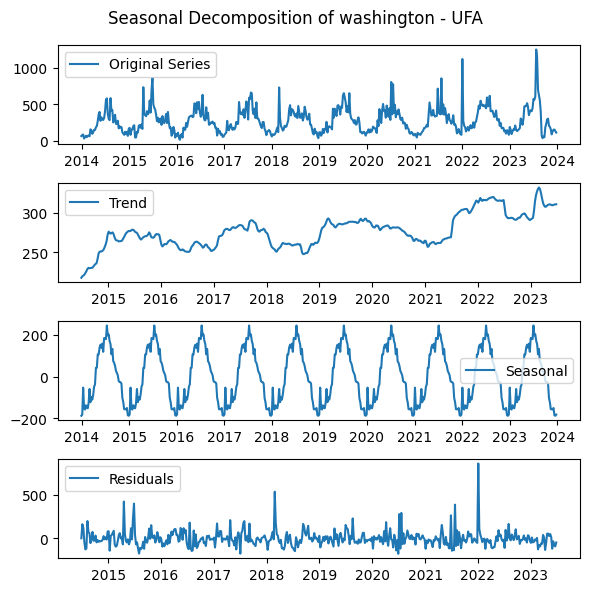

In [55]:
# city dept level data and seasonality plots
city_depts = top_depts[['city','department']].merge(city_depts, on=['city','department'], how='left')

for (city,dept), dept_df in city_depts.groupby(["city","department"]):
    # Perform seasonal decomposition on city level summary data
    dept_df.set_index("week_start", inplace=True)
    result = seasonal_decompose(dept_df['count'], model = 'additive', period=52)
    trend = result.trend.dropna()
    seasonal = result.seasonal.dropna()
    residual = result.resid.dropna()
    # Plot the decomposition
    fig = plt.figure(figsize=(6,6))
    fig.suptitle(f"Seasonal Decomposition of {city} - {dept}")
 
    plt.subplot(4, 1, 1)
    plt.plot(dept_df['count'], label='Original Series')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonal')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residuals')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [56]:
# city department level data splits

split_date = '2023-01-01'
for (city,dept), dept_df in city_depts.groupby(["city","department"]):
    train_df = dept_df[dept_df['week_start'] < split_date]
    test_df = dept_df[dept_df['week_start'] >= split_date]

    train_df.to_csv(f'../data/out/{city}_{dept}_train.csv',index=False)
    test_df.to_csv(f'../data/out/{city}_{dept}_test.csv',index=False)